# Analysis of cell count per organoid
*Author: Felix Romer*<br/>
*Data: 27/02/2024*<br/>
<br/>
The underlying data is spinning disc microscopy data of organoids, stained with DAPI. Because of technical problems (strong bleaching for nuclei in lower half of organoids) only the top half of the organoids were counted. The radius in z as well as the diameter in x and y direction where measured. With that the surface of the ellipsoid describing the organoid will be calculated.<br/>
For some organoid the attempt was made to calculate all cells. This was often not too successful.

## 1. Set up
Imports, data loading, global variables  

In [1]:
# Import needed packages
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
from scipy.special import ellipkinc, ellipeinc
from functions import ellipsoid_surface_area, calculate_difference
from matplotlib.legend_handler import HandlerTuple

#statistic
from statannot import add_stat_annotation
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Design
sns.set_context('notebook', font_scale=1.2)

# Load data
file_loc = 'Confocal image metrics data.xlsx'
Data = pd.read_excel(file_loc)

# global variables
CF_xy = 1       # is already in µm
CF_z  = 2.25

## 2. Process data
* extract experiment conditions
* calculate ellipsoid surface area
* calculate other features of interest

In [2]:
# Define a regular expression to extract one and two-digit numbers within text
# First number corresponds to the biological replication (different animal)
# Second number corresponds to the technical replication (different slide)
# Third number corresponds to the organoid number
pattern = r'(?<!\d)(\d{1,2})(?!\d)'

# Extract meta data from Name column
Data['Replication']             = Data['Name'].str.findall(pattern).str[0].astype(int)
Data['Slide_number']            = Data['Name'].str.findall(pattern).str[1].astype(int)
Data['Organoid_number']         = Data['Name'].str.findall(pattern).str[2].astype(int)
Data['Category']                = Data['Name'].apply(lambda x: 'Control' if 'Control' in x else 'H. pylori')
Data['Infection_time']          = Data['Name'].apply(lambda x: 'Early life' if 'Early life' in x else 'Late life')
Data['Condition']               = Data['Infection_time'] + " " + Data['Category']

# Scale data
Data['number slices top half']  = Data['number slices top half'].apply(calculate_difference)
Data['dz']                      = Data['number slices top half'] * CF_z

# Calculate surface of ellipsoid
Data['Ellipsoid_surface_area']  = Data.apply(lambda row: ellipsoid_surface_area(row['dz']*2, row['small diameter µm'], row['biggest diameter µm']), axis=1) /100000000
Data['cells_per_area']          = Data['number cells top half'] / Data['Ellipsoid_surface_area'] * 2
Data['cells_per_area_log']      = np.log(Data['cells_per_area'])
Data['n_cells_log']             = np.log(Data['number cells top half'])
Data['Ellipsoid_surface_area_log'] = np.log(Data['Ellipsoid_surface_area'])


# Remove untrusted datapoints
DataTrusted = Data[Data['Data trustable'] == "Yes"]

# Get Organoids that are compleatly segmented

DataVerify = DataTrusted[DataTrusted['Note'].notna() &
                         DataTrusted['Note'].str.contains('good|Good|compleat', case=False, na=False) &
                         ~ DataTrusted['Note'].str.contains('bad|Bad|bleaching', case=False, na=False)]



### 2.1 Save Dataset

In [3]:
name = file_loc.split('.')[0] + '_DataVerified.csv'
DataVerify.to_csv(name)

In [4]:
name = file_loc.split('.')[0] + '_DataTrusted.csv'
DataTrusted.to_csv(name)

#### 2.2 View Dataset

In [5]:
DataVerify.columns

Index(['Name', 'Experiment', 'Group', 'number slices top half',
       'small diameter µm', 'biggest diameter µm', 'number cells top half',
       'note for top half', 'Data trustable', 'number cells', 'Note',
       'Replication', 'Slide_number', 'Organoid_number', 'Category',
       'Infection_time', 'Condition', 'dz', 'Ellipsoid_surface_area',
       'cells_per_area', 'cells_per_area_log', 'n_cells_log',
       'Ellipsoid_surface_area_log'],
      dtype='object')

## 3. Verify if half aproach works


### 3.1 Filter

In [6]:
# Drop rows with NaN values in the specified columns
filtered_data = DataVerify[DataVerify['number cells top half'].notna() & DataVerify['number cells'].notna()]

# Convert the columns to numeric, handling non-numeric values
filtered_data['number cells top half'] = pd.to_numeric(filtered_data['number cells top half'], errors='coerce')
filtered_data['number cells'] = pd.to_numeric(filtered_data['number cells'], errors='coerce')


#### 3.1.1 Save Dataset

In [7]:
name = file_loc.split('.')[0] + '_compleat_organoid_data.csv'
filtered_data.to_csv(name)

### 3.2 Visualize

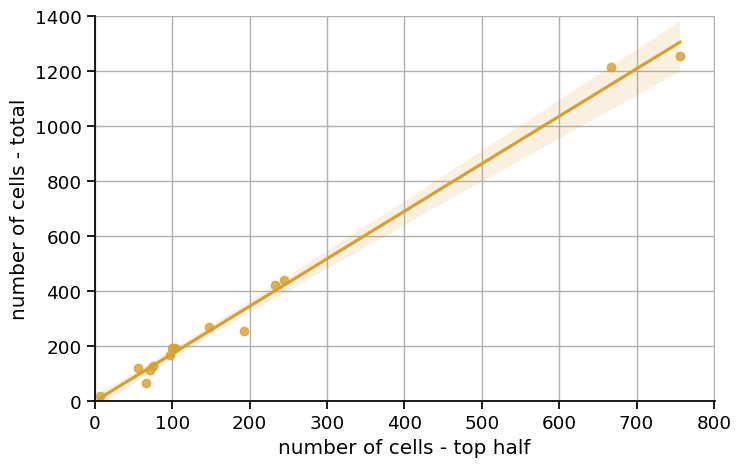

Regression Equation: y = -0.21 + 1.73 * x
R-squared: 0.99


c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  k, _ = kurtosistest(a, axis)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           number cells   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     1383.
Date:                Tue, 19 Mar 2024   Prob (F-statistic):           9.16e-14
Time:                        14:15:53   Log-Likelihood:                -69.728
No. Observations:                  14   AIC:                             143.5
Df Residuals:                      12   BIC:                             144.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.2072     13.812     -0.015      0.988     -30.301      29.887
number cells top half     1.7274      0.046     37.193      0.000       1.626       1.829
==============================================================================
Omnibus:                        2.726   Durbin-Watson:                   1.258
Prob(Omnibus):                  0.256   Jarque-Bera (JB):                1.294
Skew:                          -0.743   Prob(JB):                        0.524
Kurtosis:                       3.110   Cond. No.                         404.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
fig, ax1 = plt.subplots(figsize=(8,5))
sns.regplot(data = filtered_data,
            x = 'number cells top half',
            y = 'number cells', color = '#D8A02B',
            ax=ax1)
# Add grid
ax1.grid()
ax1.set_axisbelow(True)
ax1.set_ylabel('number of cells - total')
ax1.set_xlabel('number of cells - top half')
ax1.set_ylim(0,1400)
ax1.set_xlim(0,801)



# Remove spine
for s in ["top", "right"]:
    ax1.spines[s].set_visible(False)
# Perform the linear regression
X = sm.add_constant(filtered_data['number cells top half'])  # Add a constant term to the predictor
y = filtered_data['number cells']

model = sm.OLS(y, X).fit()

# plt.text(0.1, 0.9, summary_text, transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
plt.show()


# Get the regression results summary
summary_text = f"Regression Equation: y = {model.params['const']:.2f} + {model.params['number cells top half']:.2f} * x\nR-squared: {model.rsquared:.2f}"
print(summary_text)
display(model.summary())


### 4. Analysis of size and cell count
The untransformed and the log transformed data is shown

<>:34: SyntaxWarning: invalid escape sequence '\i'
<>:34: SyntaxWarning: invalid escape sequence '\i'
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_42988\1097109038.py:34: SyntaxWarning: invalid escape sequence '\i'
  labels=['Control', '$\it{H. Pylori}$'],
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_42988\1097109038.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_42988\1097109038.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_42988\1097109038.py:19: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\

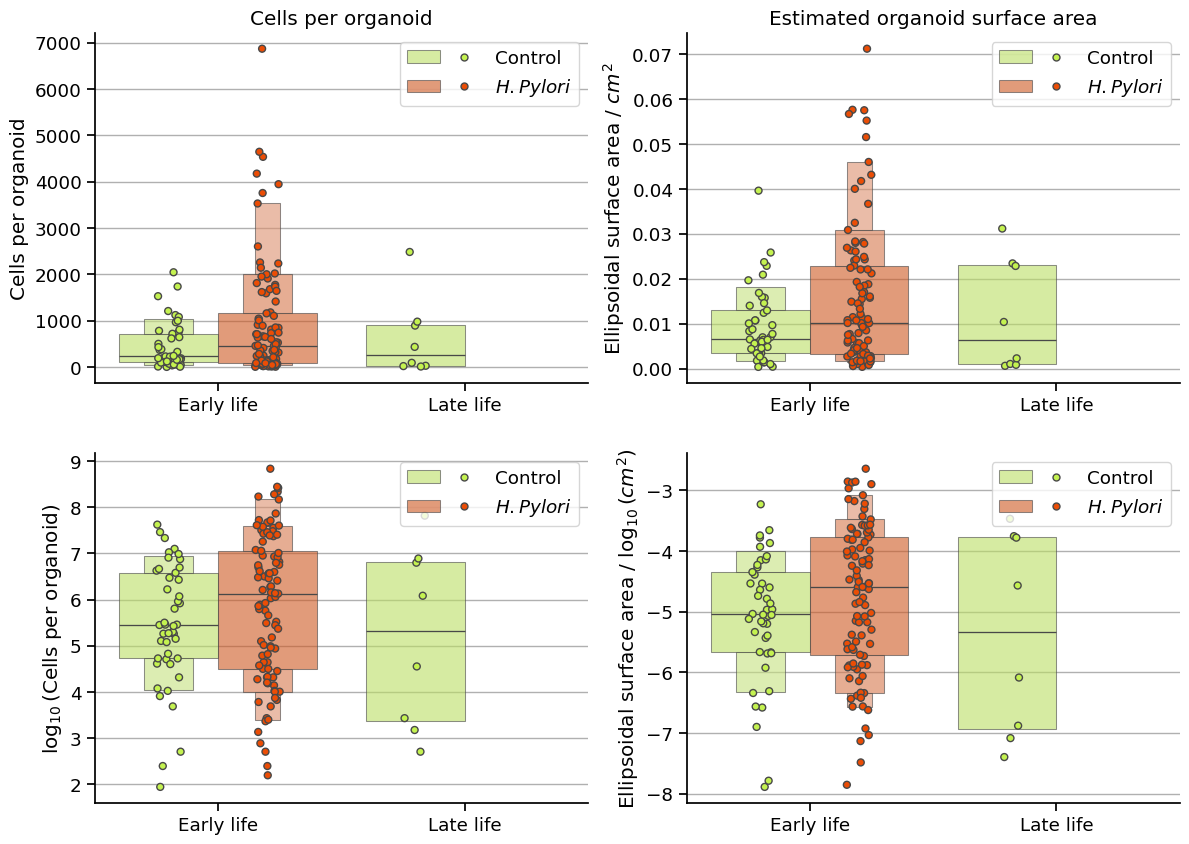

In [9]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(14,10), ncols=2, nrows=2)
for ax, feature, y_label, title in zip([ax1, ax2, ax3, ax4],
                                       ['number cells top half', 'Ellipsoid_surface_area', 'n_cells_log', 'Ellipsoid_surface_area_log'],
                                       ['Cells per organoid', 'Ellipsoidal surface area / $cm^2$', r'$\log_{10}$(Cells per organoid)', r'Ellipsoidal surface area / $\log_{10}(cm^2)$'],
                                       ['Cells per organoid', 'Estimated organoid surface area', '', '']):

    # Your boxenplot and stripplot code
    sns.boxenplot(data=DataTrusted, 
                y= feature, 
                x='Infection_time', 
                hue='Category',
                log_scale=False, 
                palette=['#c4f250', '#eb4d05'],
                box_kws={'alpha': 0.6},
                showfliers=False,
                ax=ax
                )

    sns.stripplot(data=DataTrusted,
                y= feature,
                hue="Category", 
                x="Infection_time", 
                palette=['#c4f250', '#eb4d05'],
                dodge=True,
                edgecolor='gray',
                linewidth=1,
                jitter=0.1,
                ax=ax
                )

    # Legend code (unchanged)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=['Control', '$\it{H. Pylori}$'],
            loc='best', handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None)})

    # Add grid (unchanged)
    ax.grid(axis='y')
    ax.set_axisbelow(True)
    ax.set_ylabel(y_label)
    ax.set_xlabel('')
    ax.set_title(title)

    # Remove spine (unchanged)
    for s in ["top", "right"]:
        ax.spines[s].set_visible(False)


# Show the plot
plt.show()

#### 4.2 See if effect is statistical significant
Perform a test with:
* **Response:** log(cell count) or log(area) 
* **Predictor:** Infectiontimepoint
* **Random effect:** Repition

In [10]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load your data (assuming you have a DataFrame called 'summary_od_Day6')
# Make sure 'log_Area_median' and 'count' columns exist in your data

# Fit the LME model
random_effect = "Replication"
lme_model = smf.mixedlm("n_cells_log ~ Condition", data=DataTrusted, groups=DataTrusted[random_effect])

# Get the results summary
lme_results = lme_model.fit(method=["lbfgs"])

# Print the summary
print(lme_results.summary())


                   Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       n_cells_log
No. Observations:        150           Method:                   REML       
No. Groups:              2             Scale:                    2.3251     
Min. group size:         68            Log-Likelihood:           inf        
Max. group size:         82            Converged:                Yes        
Mean group size:         75.0                                               
----------------------------------------------------------------------------
                                  Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------
Intercept                          0.000                                    
Condition[T.Early life H. pylori]  0.293    0.296  0.992 0.321 -0.286  0.873
Condition[T.Late life Control]    -0.484    0.631 -0.768 0.443 -1.720  0.752
Group Var          

c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1635: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2055: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2246: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: Co

In [11]:
# user defined R installation
import os
os.environ['R_HOME'] = 'C:/Users/felix_9ny56v1/miniconda3/envs/OrganoCellQuant/Lib/R' #path to your R installation
os.environ['R_USER'] = 'C:/Users/felix_9ny56v1/miniconda3/envs/OrganoCellQuant/Lib/rpy2' #path depends on where you installed Python.

In [12]:
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr

R[write to console]: Error: cons memory exhausted (limit reached?)



: 

In [ ]:
import rpy2.robjects.lib.ggplot2 as gp

: 

In [ ]:

# Install LMER packages (THIS TAKES ABOUT 3~5 minutes)
packnames = ('lme4', 'lmerTest', 'emmeans', "geepack")
from rpy2.robjects.packages import importr
from rpy2.robjects.vectors import StrVector
utils = importr("utils")
utils.chooseCRANmirror(ind=1)
utils.install_packages(StrVector(packnames))

R[write to console]: also installing the dependencies 'stringi', 'cli', 'glue', 'pillar', 'rlang', 'tidyselect', 'vctrs', 'stringr', 'backports', 'dplyr', 'ellipsis', 'lifecycle', 'purrr', 'tibble', 'tidyr', 'RcppEigen', 'broom'


R[write to console]: Warning:
R[write to console]:  unable to access index for repository https://cloud.r-project.org/bin/windows/contrib/3.6:
  cannot open URL 'https://cloud.r-project.org/bin/windows/contrib/3.6/PACKAGES'

R[write to console]: Packages which are only available in source form, and may need
  compilation of C/C++/Fortran: 'stringi' 'cli' 'glue' 'rlang'
  'tidyselect' 'vctrs' 'backports' 'dplyr' 'ellipsis' 'purrr' 'tibble'
  'tidyr' 'RcppEigen' 'lme4' 'geepack'



  These will not be installed


R[write to console]: installing the source packages 'pillar', 'stringr', 'lifecycle', 'broom', 'lmerTest'


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/pillar_1.9.0.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 444528 bytes (434 KB)

R[write to console]: downloaded 434 KB


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/stringr_1.5.1.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 176599 bytes (172 KB)

R[write to console]: downloaded 172 KB


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/lifecycle_1.0.4.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 107656 bytes (105 KB)

R[write to console]: downloaded 105 KB


R[write to console]: trying URL 'https://cloud.r-project.org/src/contrib/broom_1.0.5.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to

<rpy2.rinterface_lib.sexp.NULLType object at 0x0000026D1CABA990> [0]

In [ ]:
%load_ext rpy2.ipython
# Enable cell magic for Rpy2 interface

c:\Users\felix_9ny56v1\miniconda3\envs\OrganoCellQuant\Lib\site-packages\rpy2\robjects\packages.py:367: UserWarning: The symbol 'quartz' is not in this R namespace/package.
  warnings.warn(


In [ ]:
%%R 
# load LMER libraries
library(lme4)
# library(lmerTest)

# load dataset in R
# random_effect = "Replication"
# lme_model = smf.mixedlm("n_cells_log ~ Condition", data=DataTrusted, groups=DataTrusted[random_effect])
# LMER model in R
m<-lmer('n_cells_log ~ Condition + (1|Replication)', data=DataTrusted)
# print(summary(m))

Error in exists(v, envir = env, inherits = FALSE) : 
  use of NULL environment is defunct


RInterpreterError: Failed to parse and evaluate line '# load LMER libraries\nlibrary(lme4)\n# library(lmerTest)\n\n# load dataset in R\n# random_effect = "Replication"\n# lme_model = smf.mixedlm("n_cells_log ~ Condition", data=DataTrusted, groups=DataTrusted[random_effect])\n# LMER model in R\nm<-lmer(\'n_cells_log ~ Condition + (1|Replication)\', data=DataTrusted)\n# print(summary(m))\n'.
R error message: 'Error in exists(v, envir = env, inherits = FALSE) : \n  use of NULL environment is defunct'

## 3. Statistical analysis

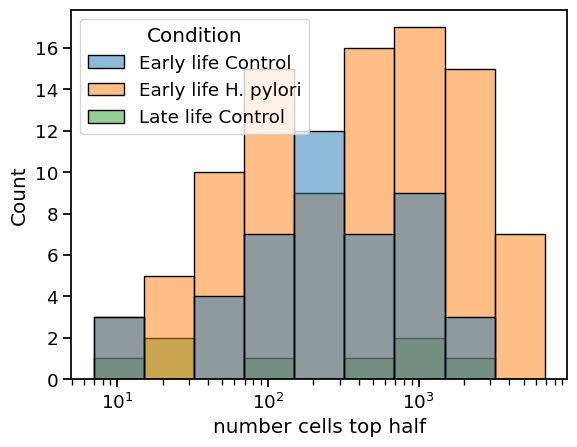

C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_102696\3386906344.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=DataTrusted, y='number cells top half', x='Condition', log_scale=False, palette=['#c4f250', '#eb4d05'],
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_102696\3386906344.py:3: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=DataTrusted, y='number cells top half', x='Condition', log_scale=False, palette=['#c4f250', '#eb4d05'],


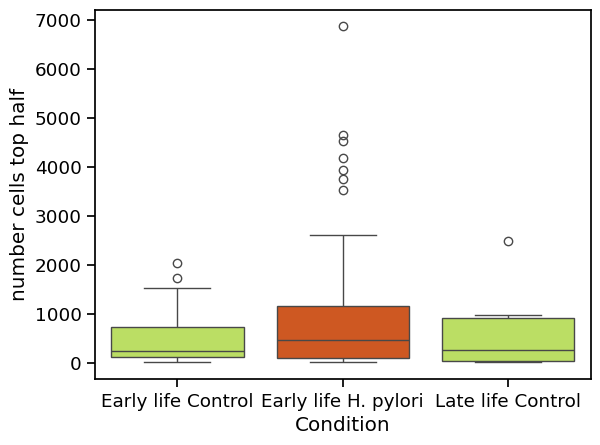

<Axes: xlabel='biggest diameter µm', ylabel='Count'>

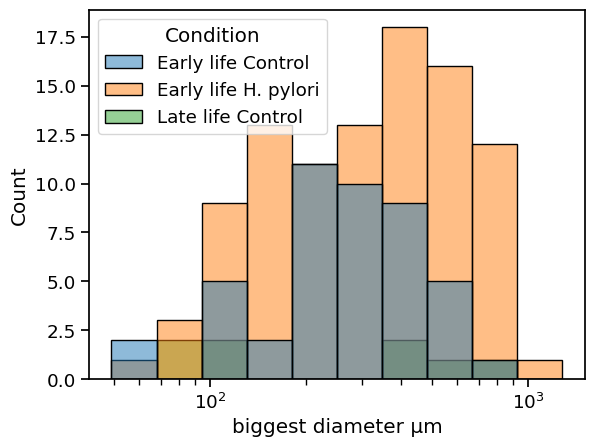

In [ ]:
sns.histplot(data=DataTrusted, x='number cells top half', hue='Condition', log_scale=True)
plt.show()
sns.boxplot(data=DataTrusted, y='number cells top half', x='Condition', log_scale=False, palette=['#c4f250', '#eb4d05'],
)
plt.show()
sns.histplot(data=DataTrusted, x='biggest diameter µm', hue='Condition', log_scale=True)


- Celldensity not normla distributet -> transform with to log space

cell count

In [11]:
from statsmodels.formula.api import poisson
DataTrusted.rename(columns={'number cells top half': 'n_cells'}, inplace=True)


model = poisson('n_cells ~ C(Condition)', data=DataTrusted).fit()
# perform post-hoc testing with Tukey's HSD test
posthoc = pairwise_tukeyhsd(DataTrusted['n_cells'], DataTrusted['Condition'])

from scikit_posthocs import posthoc_dunn

dataDunn = [DataTrusted[DataTrusted['Condition']=='Early life Control']['n_cells_log'], 
                            DataTrusted[DataTrusted['Condition']=='Early life H. pylori']['n_cells_log'],
                            DataTrusted[DataTrusted['Condition']=='Late life Control']['n_cells_log']]
# Perform post-hoc testing with Dunn's test
posthoc_dunn = posthoc_dunn(dataDunn, p_adjust='bonferroni')


# print the ANOVA table and post-hoc results
display(model.summary())

print('---------')
print(posthoc)
print('---------')
print(posthoc_dunn)

C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\1581926535.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DataTrusted.rename(columns={'number cells top half': 'n_cells'}, inplace=True)


Optimization terminated successfully.
         Current function value: 501.743685
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:                n_cells   No. Observations:                  150
Model:                        Poisson   Df Residuals:                      147
Method:                           MLE   Df Model:                            2
Date:                Tue, 19 Mar 2024   Pseudo R-squ.:                 0.05866
Time:                        13:31:47   Log-Likelihood:                -75262.
converged:                       True   LL-Null:                       -79952.
Covariance Type:            nonrobust   LLR p-value:                     0.000
========================================================================================================
                                           coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                6.1224      0.007    876.978      0.000       6.109       6.136
C(Condition)[T.Early life H. pylori]     0.6931      0.008     89.452      0.000       0.678       0.708
C(Condition)[T.Late life Control]        0.3095      0.016     19.581      0.000       0.279       0.341
========================================================================================================
"""

---------
                 Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
       group1               group2         meandiff p-adj    lower     upper   reject
-------------------------------------------------------------------------------------
  Early life Control Early life H. pylori  455.9517 0.0449    8.2542  903.6491   True
  Early life Control    Late life Control  165.4194 0.9111 -786.9802 1117.8191  False
Early life H. pylori    Late life Control -290.5322 0.7321 -1203.586  622.5215  False
-------------------------------------------------------------------------------------
---------
          1         2    3
1  1.000000  0.510626  1.0
2  0.510626  1.000000  1.0
3  1.000000  1.000000  1.0


In [12]:
model = ols('n_cells_log ~ C(Condition)', data=DataTrusted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# perform post-hoc testing with Tukey's HSD test
posthoc = pairwise_tukeyhsd(DataTrusted['n_cells_log'], DataTrusted['Condition'])

# print the ANOVA table and post-hoc results
print(anova_table)
print('---------')
print(posthoc)
print('---------')
print('---------')

model = ols('Ellipsoid_surface_area_log ~ C(Condition)', data=DataTrusted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# perform post-hoc testing with Tukey's HSD test
posthoc = pairwise_tukeyhsd(DataTrusted['Ellipsoid_surface_area_log'], DataTrusted['Condition'])

# print the ANOVA table and post-hoc results
print(anova_table)
print('---------')
print(posthoc)

                  sum_sq     df         F    PR(>F)
C(Condition)    6.879914    2.0  1.471856  0.232861
Residual      343.561963  147.0       NaN       NaN
---------
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
  Early life Control Early life H. pylori   0.3884 0.3392 -0.2645 1.0412  False
  Early life Control    Late life Control   -0.279 0.8829 -1.6678 1.1099  False
Early life H. pylori    Late life Control  -0.6674  0.463 -1.9988 0.6641  False
-------------------------------------------------------------------------------
---------
---------
                  sum_sq     df         F    PR(>F)
C(Condition)    5.260724    2.0  1.877587  0.156609
Residual      205.936260  147.0       NaN       NaN
---------
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       g

#### 3.1 H0: Cell density increases with infection

In [13]:
model = ols('cells_per_area_log ~ C(Condition)', data=DataTrusted).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
# perform post-hoc testing with Tukey's HSD test
posthoc = pairwise_tukeyhsd(DataTrusted['cells_per_area_log'], DataTrusted['Condition'])

# print the ANOVA table and post-hoc results
print(anova_table)
print('---------')
print(posthoc)

                 sum_sq     df         F    PR(>F)
C(Condition)   0.135094    2.0  0.302699  0.739281
Residual      32.803035  147.0       NaN       NaN
---------
              Multiple Comparison of Means - Tukey HSD, FWER=0.05              
       group1               group2        meandiff p-adj   lower  upper  reject
-------------------------------------------------------------------------------
  Early life Control Early life H. pylori   0.0652 0.7247 -0.1365  0.267  False
  Early life Control    Late life Control   0.0207 0.9929 -0.4085 0.4498  False
Early life H. pylori    Late life Control  -0.0446 0.9644  -0.456 0.3669  False
-------------------------------------------------------------------------------


- No significant differences between the groups. 
- H. pylori infection leads to small increase in cell density in early life
- From early to late life cell density stays more or less stabel

#### 3.2 H0: Cell density decreses when mouse is older

- See above. No significant difference

#### 3.3 H0: Correlation between celldensity and organoid size differes between conditions

In [14]:
# Assuming you have a DataFrame named 'data' with columns 'dependent_variable', 'covariate', and 'group'
formula = 'Ellipsoid_surface_area ~ cells_per_area_log + C(Condition)'
model = ols(formula, DataTrusted).fit()
print(model.summary())

# Print the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Perform post-hoc testing (Tukey's HSD) if needed
from statsmodels.stats.multicomp import pairwise_tukeyhsd

posthoc = pairwise_tukeyhsd(DataTrusted['Ellipsoid_surface_area'], DataTrusted['Condition'])
print(posthoc)

                              OLS Regression Results                              
Dep. Variable:     Ellipsoid_surface_area   R-squared:                       0.357
Model:                                OLS   Adj. R-squared:                  0.344
Method:                     Least Squares   F-statistic:                     27.07
Date:                    Tue, 19 Mar 2024   Prob (F-statistic):           5.57e-14
Time:                            13:31:50   Log-Likelihood:                 462.31
No. Observations:                     150   AIC:                            -916.6
Df Residuals:                         146   BIC:                            -904.6
Df Model:                               3                                         
Covariance Type:                nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

## 4. Visualize Data

<>:33: SyntaxWarning: invalid escape sequence '\i'
<>:33: SyntaxWarning: invalid escape sequence '\i'
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\4014898714.py:33: SyntaxWarning: invalid escape sequence '\i'
  labels=['Control', '$\it{H. Pylori}$'],
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\4014898714.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_38204\4014898714.py:18: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(data=DataTrusted,


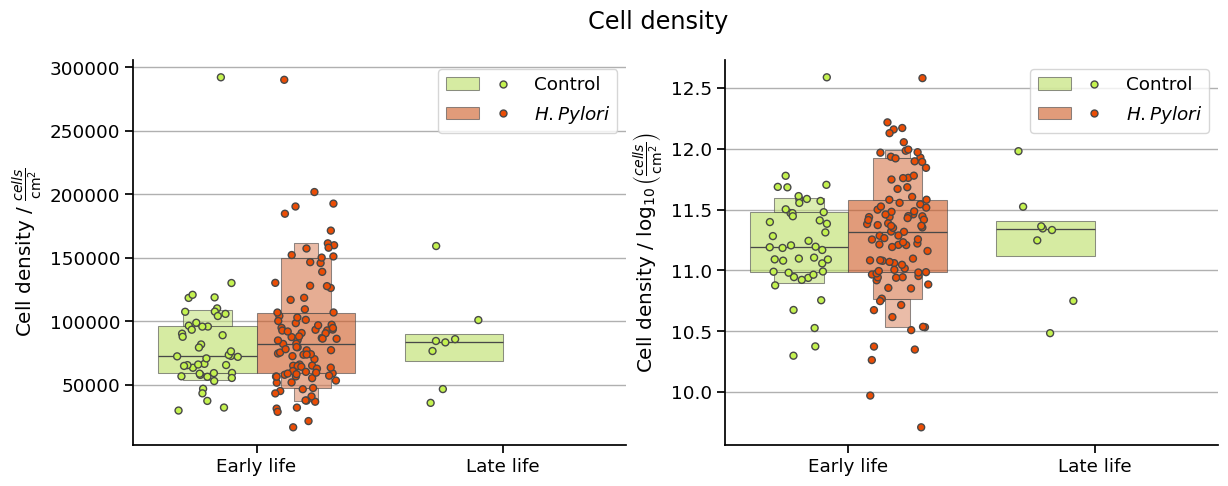

In [23]:

# Create figure and seaborn context
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(figsize=(14,10), ncols=2, nrows=2)
for ax1, feature, label in zip([ax, ax2], 
                      ['cells_per_area', 'cells_per_area_log'],
                      [r'Cell density / $\frac{cells}{\mathrm{cm}^2}$', r'Cell density / $\log_{10}\left(\frac{cells}{\mathrm{cm}^2}\right)$']
                             ):
    # Create the plot
    sns.boxenplot(y=feature,
    hue="Category",
    palette=['#c4f250', '#eb4d05'],
    data=DataTrusted,
    x = 'Infection_time',
    box_kws={'alpha': 0.6},
    showfliers = False,
    ax=ax1
    )

    sns.stripplot(data=DataTrusted,
    y=feature,
    hue="Category", 
    x="Infection_time", 
    palette=['#c4f250', '#eb4d05'],
    dodge=True,
    edgecolor='gray',
    linewidth=1,
    jitter = 0.25,
    ax=ax1)


    handles, labels = ax1.get_legend_handles_labels()

    ax1.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
            labels=['Control', '$\it{H. Pylori}$'],
            loc='best', handlelength=4,
            handler_map={tuple: HandlerTuple(ndivide=None)})



    # Add grid
    ax1.grid(axis='y')
    ax1.set_axisbelow(True)
    ax1.set_ylabel(label)
    ax1.set_xlabel('')


    # Remove spine
    for s in ["top", "right"]:
        ax1.spines[s].set_visible(False)

# Show the plot
fig.suptitle('Cell density')
plt.show()

<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
<>:13: SyntaxWarning: invalid escape sequence '\i'
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_42988\390797566.py:13: SyntaxWarning: invalid escape sequence '\i'
  lables=['Early life - Control', 'Early life - $\it{H. Pylori}$', 'Late life - Control', 'Late life - $\it{H. Pylori}$']
C:\Users\felix_9ny56v1\AppData\Local\Temp\ipykernel_42988\390797566.py:13: SyntaxWarning: invalid escape sequence '\i'
  lables=['Early life - Control', 'Early life - $\it{H. Pylori}$', 'Late life - Control', 'Late life - $\it{H. Pylori}$']


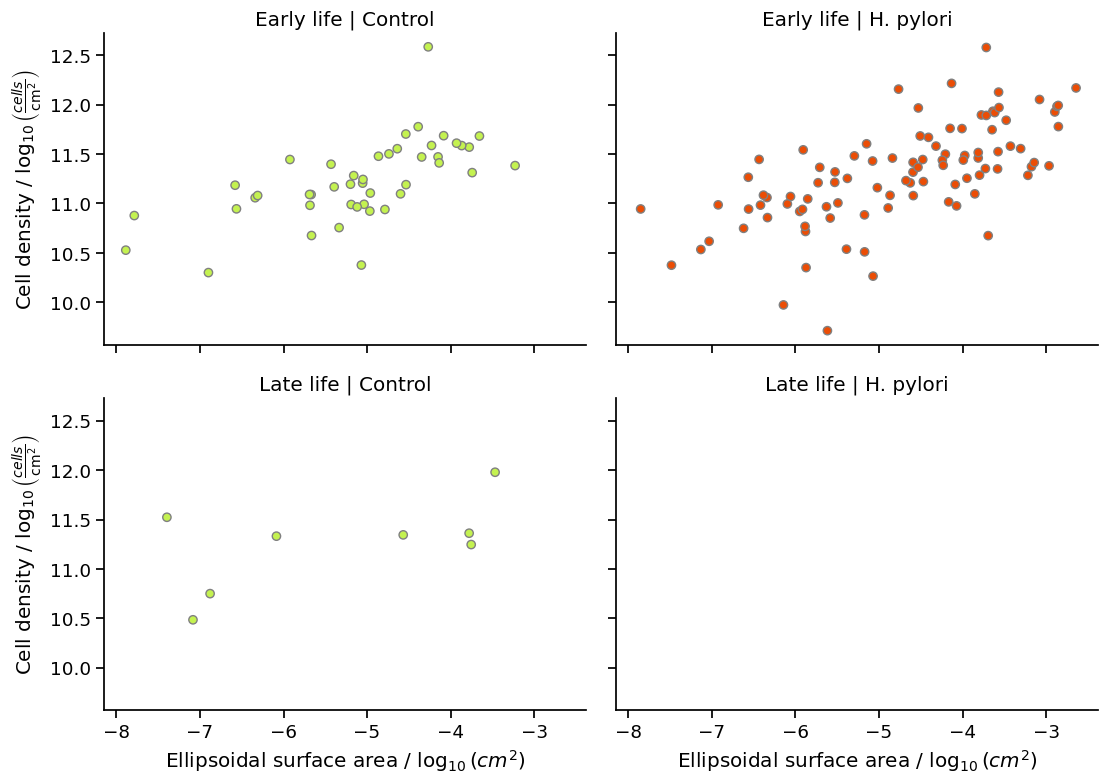

In [40]:
a=sns.relplot(data= DataTrusted,
            x='Ellipsoid_surface_area_log',
            y='cells_per_area_log',
            kind='scatter',
            hue="Category",
            col="Category",
            row='Infection_time',
            edgecolor='gray',
            linewidth=1,
            palette=['#c4f250', '#eb4d05'],
            height=4,
            aspect=1.4)
lables=['Early life - Control', 'Early life - $\it{H. Pylori}$', 'Late life - Control', 'Late life - $\it{H. Pylori}$']
a.set_titles(row_template="{row_name}", col_template="{col_name}")
a._legend.remove()
a.set_axis_labels(r'Ellipsoidal surface area / $\log_{10}(cm^2)$', r'Cell density / $\log_{10}\left(\frac{cells}{\mathrm{cm}^2}\right)$')

In [ ]:
data=phys_df, x='variable', y='value', kind='box', hue="Wine type", col="name",
                 col_wrap=4, sharey=False, sharex=False, palette=color_wine

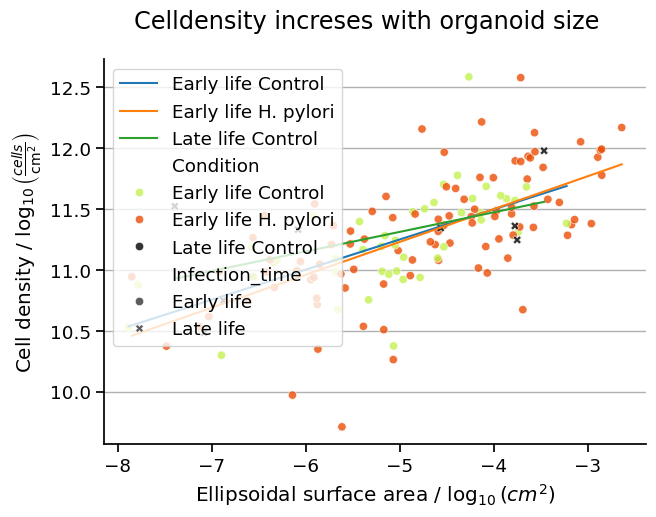

In [45]:
# Fit a linear regression model for each group
fig, ax1 = plt.subplots(figsize=(7,5), n)

for group, group_data in DataTrusted.groupby('Condition'):
    model_group = ols(f'cells_per_area_log ~ Ellipsoid_surface_area_log', data=group_data).fit()
    
    # Add the linear regression line
    sns.lineplot(x=group_data['Ellipsoid_surface_area_log'], y=model_group.fittedvalues,label=f'{group}', ax= ax1)

    # Create a scatter plot
    sns.scatterplot(y='cells_per_area_log', 
                    x='Ellipsoid_surface_area_log',
                    data=DataTrusted, 
                    hue="Condition",
                    palette=['#c4f250', '#eb4d05', 'black'],
                    style='Infection_time',
                    alpha=0.8,
                    ax= ax1)

handles, labels = ax1.get_legend_handles_labels()

# ax1.legend(handles=[(),(handles[0], handles[3]), (handles[1], handles[3]), (), (handles[1], handles[3]), (handles[1], handles[3])],
#         labels=['Infection', 'Control', '$\it{H. Pylori}$', 'Time of infection', 'Early life', 'Late life'],
#         loc='best', handlelength=6,
#         handler_map={tuple: HandlerTuple(ndivide=None)})



# Add grid
ax1.grid(axis='y')
ax1.set_axisbelow(True)
ax1.set_ylabel(label)
ax1.set_xlabel(r'Ellipsoidal surface area / $\log_{10}(cm^2)$')
fig.suptitle('Celldensity increses with organoid size')

# Remove spine
for s in ["top", "right"]:
    ax1.spines[s].set_visible(False)

plt.show()


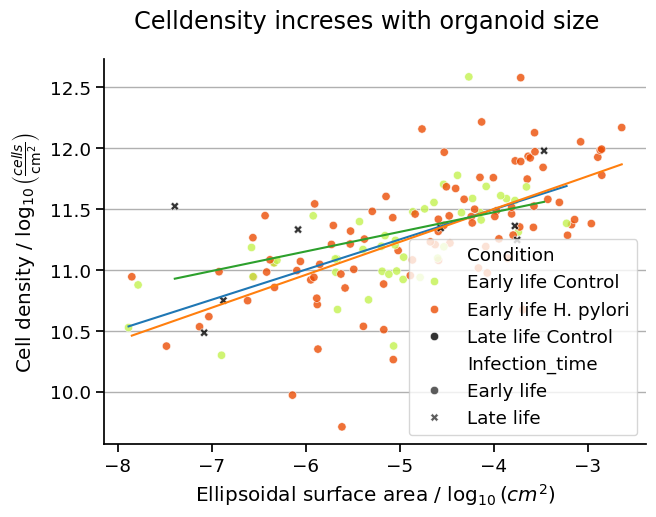

In [39]:
# Fit a linear regression model for each group
for group, group_data in DataTrusted.groupby('Condition'):
    model_group = ols(f'cells_per_area_log ~ Ellipsoid_surface_area_log', data=group_data).fit()
    
    # Create a scatter plot
    sns.scatterplot(y='cells_per_area_log', x='Ellipsoid_surface_area_log', data=group_data)
    
    # Add the linear regression line
    sns.lineplot(x=group_data['Ellipsoid_surface_area_log'], y=model_group.fittedvalues, label=f'{group}')
